In [1]:
import sys
import random
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.transform import resize
from skimage.morphology import label

# from keras.models import Model, load_model
# from keras.layers import Input
# from keras.layers.core import Dropout, Lambda
# from keras.layers.convolutional import Conv2D, Conv2DTranspose
# from keras.layers.pooling import MaxPooling2D
# from keras.layers.merge import concatenate
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras import backend as K


from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import callbacks
import glob

from PIL import Image
import glob

import tensorflow as tf
import time

In [2]:
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
#TRAIN_PATH = './dataset/training/'
#TEST_PATH = './dataset/testing/'
TRAIN_NUM = 1700
TEST_NUM = 300
sample_dir = "../training/sample/"
mask_dir = "../training/mask/"
test_sample_dir = "../testing/sample/"
test_mask_dir = "../testing/mask/"


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

#### sample_ids
* contain all the names of sample and mask data IN TRAINING SET
* mask_ids = sample_ids + "_matte.png"

#### test_sample_ids
* contain all the names of sample and mask data IN TESTING SET
* test_mask_ids = test_sample_ids + "_matte.png"


In [3]:
#Get the filenames of training and testing data
sample_ids = next(os.walk(sample_dir))[2]
test_sample_ids = next(os.walk(test_sample_dir))[2]
print(sample_ids[:10])
print(test_sample_ids[:10])

['01255.png', '00956.png', '00762.png', '00086.png', '00005.png', '01468.png', '01682.png', '00334.png', '00291.png', '00346.png']
['00086.png', '00005.png', '00291.png', '00184.png', '00046.png', '00038.png', '00170.png', '00224.png', '00203.png', '00264.png']


In [4]:
#First create several np arrays with the correct shapes
# X_train = np.zeros((len(sample_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_train = np.zeros((len(sample_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

In [5]:
#First create several np arrays with the correct shapes
# X_test = np.zeros((len(test_sample_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_test = np.zeros((len(test_sample_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

### Getting the training data ready loaded into X_train and Y_train

In [6]:
# X_train = []
# Y_train = []

# THRES = 70
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(sample_ids), total=TRAIN_NUM):
#     sample_path = sample_dir + id_
#     # also read in the corresponding mask
#     mask_path = mask_dir + id_[:-4] + "_matte.png"
    
#     img = imread(sample_path)
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     img = img.astype(np.float32)
#     X_train.append(img)
    
#     mask_ = imread(mask_path)
#     mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                             preserve_range=True), axis=-1)
    
#     mask_ = (mask_ > THRES) * 255
#     mask_= mask_.astype(np.float32)
#     Y_train.append(mask_)

In [7]:
# X_test = []
# Y_test = []
# THRES = 70
# for n, id_ in tqdm(enumerate(test_sample_ids), total=TEST_NUM):
#     test_sample_path = test_sample_dir + id_
#     # also read in the corresponding mask
#     test_mask_path = test_mask_dir + id_[:-4] + "_matte.png"
    
#     img = imread(test_sample_path)
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     img = img.astype(np.float32)
#     X_test.append(img)
    
#     mask_ = imread(test_mask_path)
#     mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                             preserve_range=True), axis=-1)
    
#     mask_ = (mask_ > THRES) * 255
# #     print(mask_.dtype)
#     mask_ = mask_.astype(np.float32)
# #     print(mask_.dtype)
#     Y_test.append(mask_)

In [8]:
#NOW examine if our data preprocessing is done correctly
# someImg = random.choice(Y_train)
# print(X_train[100].dtype)
someImg = X_train[100].astype(np.uint8)
plt.imshow(someImg)
plt.show()

anotherImg = Y_train[100].astype(np.uint8)
# print(Y_train.shape)
# plt.imshow(anotherImg[:,:,0], cmap = "Greys")
plt.imshow(anotherImg[:,:,0], cmap = 'Greys')
print(anotherImg.dtype)
plt.show()

print(anotherImg[200:300,200:300,0])

NameError: name 'X_train' is not defined

In [ ]:
#NOW examine if our data preprocessing is done correctly
# someImg = random.choice(Y_train)
someImg = X_test[200].astype(np.uint8)
plt.imshow(someImg)
plt.show()

anotherImg = Y_test[200].astype(np.uint8)
# print(Y_train.shape)
# plt.imshow(anotherImg[:,:,0], cmap = "Greys")
plt.imshow(anotherImg[:,:,0], cmap = "Greys")
plt.show()

print(anotherImg[200:300,200:300,0])

### Building the model here

In [9]:
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

In [10]:
img_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
inputs = layers.Input(shape=img_shape)
# 256
encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16
encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8
center = conv_block(encoder4_pool, 1024)
# center
decoder4 = decoder_block(center, encoder4, 512)
# 16
decoder3 = decoder_block(decoder4, encoder3, 256)
# 32
decoder2 = decoder_block(decoder3, encoder2, 128)
# 64
decoder1 = decoder_block(decoder2, encoder1, 64)
# 128
decoder0 = decoder_block(decoder1, encoder0, 32)
# 256
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

model = None
model = models.Model(inputs=[inputs], outputs=[outputs])

model.summary()

W0728 01:49:28.635933 140575159953152 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [12]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [13]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [14]:
!ls -al

total 1098028
drwxr-xr-x  5 tomZhou tomZhou      4096 Jul 27 18:30 .
drwxr-xr-x 19 tomZhou tomZhou      4096 Jul 27 09:51 ..
-rw-r--r--  1 tomZhou tomZhou    355674 Jul 26 07:09 augmented_pictures.zip
-rw-r--r--  1 tomZhou tomZhou 373905152 Jul 26 16:02 baseline_weights.hdf5
-rw-r--r--  1 tomZhou tomZhou    393473 Jul 27 13:00 Compare_PIL_with_Skimage.ipynb
-rw-r--r--  1 tomZhou tomZhou     69136 Jul 26 07:52 data_aug_cifar10.ipynb
drwxr-xr-x  8 tomZhou tomZhou      4096 Jul 26 13:13 .git
drwxr-xr-x  2 tomZhou tomZhou      4096 Jul 27 13:37 .ipynb_checkpoints
-rw-r--r--  1 tomZhou tomZhou 373906152 Jul 27 18:29 maybe_overfitting.hdf5
drwxr-xr-x  2 tomZhou tomZhou      4096 Jul 26 06:53 models
-rw-r--r--  1 tomZhou tomZhou      5276 Jul 27 13:15 Old_img_generator.ipynb
-rw-r--r--  1 tomZhou tomZhou   1763118 Jul 27 18:30 Pioneer_main.ipynb
-rw-r--r--  1 tomZhou tomZhou     21585 Jul 26 06:16 Skimage_learning.ipynb
-rw-r--r--  1 tomZhou tomZhou      6358 Jul 26 06:16 skimage_nupmy.ipynb


In [15]:
save_model_path = './weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', save_best_only=True, verbose=1)

### Use a custom data generator

In [16]:
from tensorflow.keras.preprocessing.image import *

# Create an ImageDataGenerator object and perform data augmentation
train_datagen = ImageDataGenerator(
#     featurewise_center=True,
    rescale = 1./255, # This step is crucial
    rotation_range = 0.,
    shear_range = 0.,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    horizontal_flip= False
    )

# train_datagen = ImageDataGenerator(
#     rescale = 1./255, # This step is crucial
#     )

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [17]:
# sample_dir = "../big_dataset/train/img/"
# mask_dir = "../big_dataset/train/mask/"
# test_sample_dir = "../big_dataset/test/img/"
# test_mask_dir = "../big_dataset/test/mask"

sample_dir = "../training/sample/"
mask_dir = "../training/mask/"
test_sample_dir = "../testing/sample/"
test_mask_dir = "../testing/mask/"

batch_size = 10

class DataGenerator(tf.keras.utils.Sequence):
#     'Generates data for Keras'
    def __init__(self, train_im_path=sample_dir,train_mask_path=mask_dir,
                 augmentations=None, batch_size=batch_size,img_size=512, n_channels=3, shuffle=True):
#         'Initialization'
        self.batch_size = batch_size
        self.train_im_paths = glob.glob(train_im_path+'*')
        
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path

        self.img_size = img_size
        
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.on_epoch_end()

    def __len__(self):
#         'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.train_im_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_paths))]

        # Find list of IDs
        list_IDs_im = [self.train_im_paths[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_im)
        
#         for i in range(batch_size):
#             print("Img come out", X[i,150:160, 150:160])
            
        # First generate data
        #Then rescale them
        #ONLY rescaled mask data
        

        if self.augment is None:
            
#             print(X.dtype)
#             y = np.array(y)
#             print(y.dtype)
            return X,np.array(y)
        else:            
            im,mask = [],[]   
            for x,y in zip(X,y):
                augmented = self.augment(image=x, mask=y)
                im.append(augmented['image'])
                mask.append(augmented['mask'])
            return np.array(im),np.array(mask)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.train_im_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_im):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(list_IDs_im),self.img_size,self.img_size, self.n_channels))
        y = np.empty((len(list_IDs_im),self.img_size,self.img_size, 1))
        # Generate data
        for i, im_path in enumerate(list_IDs_im):
            
            im = np.array(Image.open(im_path))
            mask_path = im_path.replace(self.train_im_path,self.train_mask_path)
            mask_path = mask_path[:-4]+"_matte.png"
            mask = np.array(Image.open(mask_path))
            
#             print("img feed in", im[150:160, 150:160])
            
            if len(im.shape)==2:
                print("shape before:", im.shape)
                im = np.repeat(im[...,None],3,2)
                print("shape after:",im.shape)
                
#             # Resize sample
            X[i,] = resize(im,(self.img_size,self.img_size))
#             X[i,] = resize(im,(800, 500))
            y[i,] = resize(mask,(self.img_size,self.img_size))[..., np.newaxis]
        

            #NOTE that after skimage.transform.resize, the pixel value range of
            #the mask is already between 0 and 1. No NEED TO DIVIDE by 255
            y[y>0.25] = 1.0
            y[y <0.25] = 0.0
        
        return X,y #They are both in float64 now because I used the rubbish skimage

In [18]:
# train_datagen.fit(X_train, seed = 4)


-----------------------------------------

(512, 512, 3)
(512, 512, 1)
img dtype:
float64
mask dtype:
float64


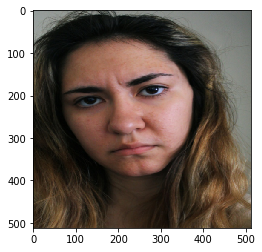

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


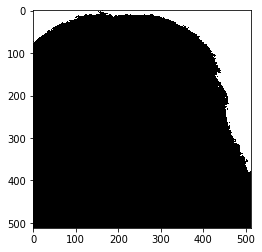

(512, 512, 3)
(512, 512, 1)
img dtype:
float64
mask dtype:
float64


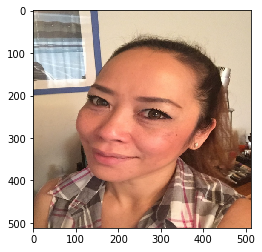

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


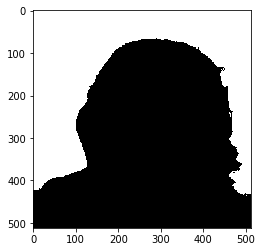

(512, 512, 3)
(512, 512, 1)
img dtype:
float64
mask dtype:
float64


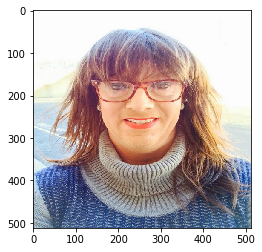

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


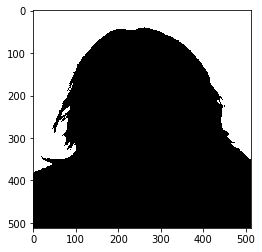

(512, 512, 3)
(512, 512, 1)
img dtype:
float64
mask dtype:
float64


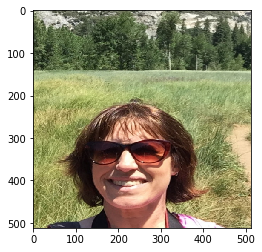

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


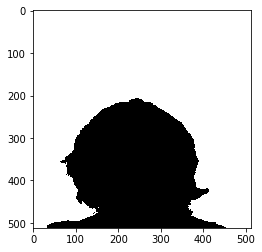

(512, 512, 3)
(512, 512, 1)
img dtype:
float64
mask dtype:
float64


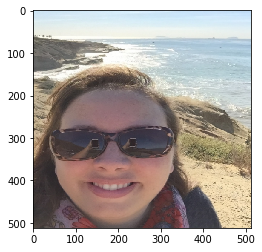

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


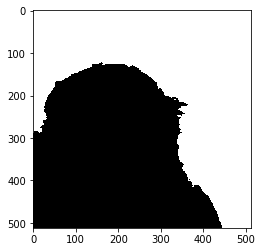

(512, 512, 3)
(512, 512, 1)
img dtype:
float64
mask dtype:
float64


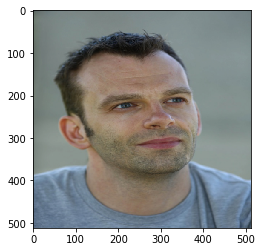

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


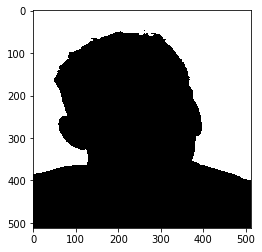

(512, 512, 3)
(512, 512, 1)
img dtype:
float64
mask dtype:
float64


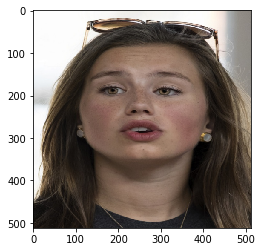

[[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


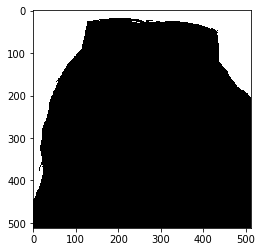

(512, 512, 3)
(512, 512, 1)
img dtype:
float64
mask dtype:
float64


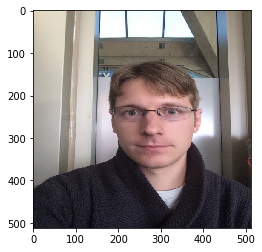

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


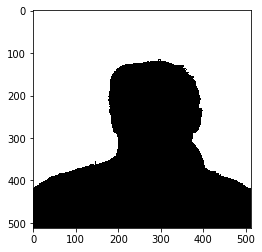

(512, 512, 3)
(512, 512, 1)
img dtype:
float64
mask dtype:
float64


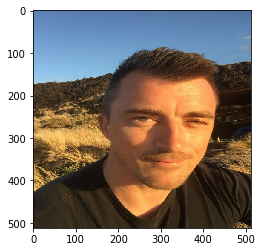

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


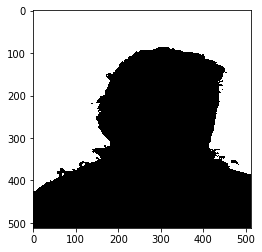

(512, 512, 3)
(512, 512, 1)
img dtype:
float64
mask dtype:
float64


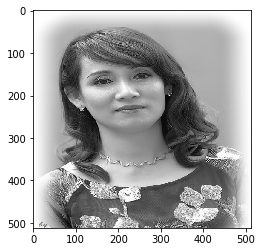

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


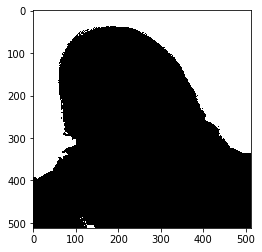

In [23]:
a = DataGenerator(batch_size=10,shuffle=False)
gen_images,gen_masks = a.__getitem__(0)
max_images = 10
grid_width = 2
# grid_height = int(max_images / grid_width)
# fig, axs = plt.subplots(grid_height, grid_width, figsize=(10, 10))

# for i,(im, mask) in enumerate(zip(images,masks)):
#     ax = axs[int(i / grid_width), i % grid_width]
# #     ax.imshow(im[:,:,0])
#     ax.imshow(mask.squeeze(),cmap="Greys")    
#     ax.axis('off')
# plt.suptitle("Example Training Masks")
print()
print("-----------------------------------------")
print()
for i in range(10):
    img = gen_images[i]
    gt = gen_masks[i]

    print(img.shape)
    print(gt.shape)
    
    print("img dtype:")
    print(img.dtype)
    
    print("mask dtype:")
    print(gt.dtype)
    
    plt.imshow(img)
    plt.show()

    plt.imshow(gt.squeeze(), cmap = "Greys")
    print(gt.squeeze()[100:110, 100:110])
    plt.show()
    
# fig, axs_2 = plt.subplots(grid_height, grid_width, figsize=(10, 10))
# for i,(im, mask) in enumerate(zip(images,masks)):
#     ax = axs_2[int(i / grid_width), i % grid_width]
#     ax.imshow(im)    
#     ax.axis('off')
# plt.suptitle("Example Training Pictures")

In [19]:
# Here the two generators are instantiated to fit in the model.fit_generator()
# batchSize = 15
training_generator = DataGenerator(augmentations=None,img_size=IMG_HEIGHT)
validation_generator = DataGenerator(train_im_path = test_sample_dir ,
                                     train_mask_path=test_mask_dir,augmentations=None,
                                     img_size=IMG_HEIGHT)


In [20]:
X_train = None
Y_train = None

## Compile or load the model

In [30]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

W0727 15:25:32.361830 140092767188736 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
# Alternatively, load the weights directly: model.load_weights(save_model_path)
# !ls -al
model = models.load_model("./weights.hdf5", custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

W0728 01:50:49.597541 140575159953152 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0728 01:50:49.598840 140575159953152 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0728 01:50:49.601100 140575159953152 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecat

In [24]:
# from tensorflow.keras.utils import multi_gpu_model
# parallel_model = multi_gpu_model(model, gpus=2)

In [25]:
# parallel_model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

In [26]:
# gpu_options = tf.GPUOptions(allow_growth=True)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [32]:
# print(X_train[0].shape)
# print(Y_train[0].shape)
# print(len(X_train))
# print(len(Y_train))

# X_train = np.array(X_train)
# Y_train = np.array(Y_train)

# X_test = np.array(X_test)
# Y_test = np.array(Y_test)

# print(X_train.shape)
# print(Y_train.shape)
# print(X_train.dtype)
# print(Y_train.dtype)

In [33]:
# history = model.fit(X_train, Y_train, batch_size = batchSize, epochs = 5, 
#                     shuffle =True, validation_data = (X_test, Y_test))

In [22]:
history = model.fit_generator(training_generator,
                    epochs=40,
                    validation_data = validation_generator,
                    callbacks=[cp],
                    verbose =1,
                    validation_freq=2,
                    workers=6
                    )


Epoch 1/40


/usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/api/_v1/keras/preprocessing/image/__init__.py:102: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/api/_v1/keras/preprocessing/image/__init__.py:103: RuntimeWarning: invalid value encountered in less


169/170 [============================>.] - ETA: 0s - loss: 0.1776 - dice_loss: 0.0513

W0728 01:53:22.429045 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 135s 792ms/step - loss: 0.1774 - dice_loss: 0.0513
Epoch 2/40
169/170 [============================>.] - ETA: 0s - loss: 0.1764 - dice_loss: 0.0513
Epoch 00002: val_loss improved from inf to 0.22159, saving model to ./weights.hdf5
170/170 [==============================] - 165s 972ms/step - loss: 0.1766 - dice_loss: 0.0513 - val_loss: 0.2216 - val_dice_loss: 0.0537
Epoch 3/40
169/170 [============================>.] - ETA: 0s - loss: 0.1553 - dice_loss: 0.0446

W0728 01:58:08.928442 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 121s 713ms/step - loss: 0.1551 - dice_loss: 0.0446
Epoch 4/40
169/170 [============================>.] - ETA: 0s - loss: 0.1616 - dice_loss: 0.0458
Epoch 00004: val_loss did not improve from 0.22159
170/170 [==============================] - 153s 901ms/step - loss: 0.1615 - dice_loss: 0.0458 - val_loss: 0.2312 - val_dice_loss: 0.0570
Epoch 5/40
169/170 [============================>.] - ETA: 0s - loss: 0.1432 - dice_loss: 0.0416

W0728 02:02:44.401783 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 122s 719ms/step - loss: 0.1432 - dice_loss: 0.0416
Epoch 6/40
169/170 [============================>.] - ETA: 0s - loss: 0.1385 - dice_loss: 0.0399
Epoch 00006: val_loss improved from 0.22159 to 0.21854, saving model to ./weights.hdf5
170/170 [==============================] - 155s 914ms/step - loss: 0.1389 - dice_loss: 0.0400 - val_loss: 0.2185 - val_dice_loss: 0.0502
Epoch 7/40
169/170 [============================>.] - ETA: 0s - loss: 0.1331 - dice_loss: 0.0380

W0728 02:07:22.122720 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 122s 719ms/step - loss: 0.1332 - dice_loss: 0.0381
Epoch 8/40
169/170 [============================>.] - ETA: 0s - loss: 0.1314 - dice_loss: 0.0380
Epoch 00008: val_loss improved from 0.21854 to 0.21559, saving model to ./weights.hdf5
170/170 [==============================] - 156s 920ms/step - loss: 0.1312 - dice_loss: 0.0379 - val_loss: 0.2156 - val_dice_loss: 0.0562
Epoch 9/40
169/170 [============================>.] - ETA: 0s - loss: 0.1171 - dice_loss: 0.0337

W0728 02:12:00.317809 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 122s 716ms/step - loss: 0.1175 - dice_loss: 0.0338
Epoch 10/40
169/170 [============================>.] - ETA: 0s - loss: 0.1101 - dice_loss: 0.0316
Epoch 00010: val_loss did not improve from 0.21559
170/170 [==============================] - 159s 935ms/step - loss: 0.1102 - dice_loss: 0.0316 - val_loss: 0.2476 - val_dice_loss: 0.0511
Epoch 11/40
169/170 [============================>.] - ETA: 0s - loss: 0.1152 - dice_loss: 0.0328

W0728 02:16:45.476491 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 126s 741ms/step - loss: 0.1152 - dice_loss: 0.0328
Epoch 12/40
169/170 [============================>.] - ETA: 0s - loss: 0.0983 - dice_loss: 0.0280
Epoch 00012: val_loss improved from 0.21559 to 0.19114, saving model to ./weights.hdf5
170/170 [==============================] - 158s 929ms/step - loss: 0.0983 - dice_loss: 0.0281 - val_loss: 0.1911 - val_dice_loss: 0.0430
Epoch 13/40
169/170 [============================>.] - ETA: 0s - loss: 0.1127 - dice_loss: 0.0321

W0728 02:21:26.253069 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 123s 722ms/step - loss: 0.1125 - dice_loss: 0.0320
Epoch 14/40
169/170 [============================>.] - ETA: 0s - loss: 0.1020 - dice_loss: 0.0289
Epoch 00014: val_loss did not improve from 0.19114
170/170 [==============================] - 154s 904ms/step - loss: 0.1021 - dice_loss: 0.0289 - val_loss: 0.2622 - val_dice_loss: 0.0591
Epoch 15/40
169/170 [============================>.] - ETA: 0s - loss: 0.0876 - dice_loss: 0.0253

W0728 02:26:03.246785 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 123s 725ms/step - loss: 0.0874 - dice_loss: 0.0252
Epoch 16/40
169/170 [============================>.] - ETA: 0s - loss: 0.0937 - dice_loss: 0.0267
Epoch 00016: val_loss improved from 0.19114 to 0.18666, saving model to ./weights.hdf5
170/170 [==============================] - 157s 922ms/step - loss: 0.0935 - dice_loss: 0.0266 - val_loss: 0.1867 - val_dice_loss: 0.0449
Epoch 17/40
169/170 [============================>.] - ETA: 0s - loss: 0.0869 - dice_loss: 0.0249

W0728 02:30:40.439389 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 120s 708ms/step - loss: 0.0869 - dice_loss: 0.0249
Epoch 18/40
169/170 [============================>.] - ETA: 0s - loss: 0.0789 - dice_loss: 0.0227
Epoch 00018: val_loss did not improve from 0.18666
170/170 [==============================] - 155s 912ms/step - loss: 0.0789 - dice_loss: 0.0227 - val_loss: 0.2009 - val_dice_loss: 0.0414
Epoch 19/40
169/170 [============================>.] - ETA: 0s - loss: 0.0761 - dice_loss: 0.0217

W0728 02:35:17.190104 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 122s 715ms/step - loss: 0.0759 - dice_loss: 0.0217
Epoch 20/40
169/170 [============================>.] - ETA: 0s - loss: 0.0664 - dice_loss: 0.0191
Epoch 00020: val_loss did not improve from 0.18666
170/170 [==============================] - 153s 897ms/step - loss: 0.0664 - dice_loss: 0.0191 - val_loss: 0.1889 - val_dice_loss: 0.0379
Epoch 21/40
169/170 [============================>.] - ETA: 0s - loss: 0.0586 - dice_loss: 0.0169

W0728 02:39:52.964925 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 123s 725ms/step - loss: 0.0586 - dice_loss: 0.0168
Epoch 22/40
169/170 [============================>.] - ETA: 0s - loss: 0.0626 - dice_loss: 0.0180
Epoch 00022: val_loss did not improve from 0.18666
170/170 [==============================] - 152s 892ms/step - loss: 0.0628 - dice_loss: 0.0180 - val_loss: 0.1919 - val_dice_loss: 0.0363
Epoch 23/40
169/170 [============================>.] - ETA: 0s - loss: 0.0592 - dice_loss: 0.0171

W0728 02:44:26.639369 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 122s 718ms/step - loss: 0.0593 - dice_loss: 0.0171
Epoch 24/40
169/170 [============================>.] - ETA: 0s - loss: 0.0906 - dice_loss: 0.0256
Epoch 00024: val_loss did not improve from 0.18666
170/170 [==============================] - 150s 885ms/step - loss: 0.0913 - dice_loss: 0.0257 - val_loss: 0.2391 - val_dice_loss: 0.0503
Epoch 25/40
169/170 [============================>.] - ETA: 0s - loss: 0.0623 - dice_loss: 0.0181

W0728 02:48:59.759231 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 123s 721ms/step - loss: 0.0623 - dice_loss: 0.0181
Epoch 26/40
169/170 [============================>.] - ETA: 0s - loss: 0.0540 - dice_loss: 0.0156
Epoch 00026: val_loss improved from 0.18666 to 0.18396, saving model to ./weights.hdf5
170/170 [==============================] - 152s 894ms/step - loss: 0.0539 - dice_loss: 0.0156 - val_loss: 0.1840 - val_dice_loss: 0.0351
Epoch 27/40
169/170 [============================>.] - ETA: 0s - loss: 0.0541 - dice_loss: 0.0156

W0728 02:53:32.897782 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 121s 713ms/step - loss: 0.0544 - dice_loss: 0.0157
Epoch 28/40
169/170 [============================>.] - ETA: 0s - loss: 0.0550 - dice_loss: 0.0160
Epoch 00028: val_loss improved from 0.18396 to 0.18176, saving model to ./weights.hdf5
170/170 [==============================] - 152s 892ms/step - loss: 0.0549 - dice_loss: 0.0160 - val_loss: 0.1818 - val_dice_loss: 0.0365
Epoch 29/40
169/170 [============================>.] - ETA: 0s - loss: 0.0518 - dice_loss: 0.0149

W0728 02:58:06.658658 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 122s 717ms/step - loss: 0.0518 - dice_loss: 0.0149
Epoch 30/40
169/170 [============================>.] - ETA: 0s - loss: 0.0439 - dice_loss: 0.0127
Epoch 00030: val_loss did not improve from 0.18176
170/170 [==============================] - 155s 915ms/step - loss: 0.0442 - dice_loss: 0.0128 - val_loss: 0.2077 - val_dice_loss: 0.0369
Epoch 31/40
169/170 [============================>.] - ETA: 0s - loss: 0.0550 - dice_loss: 0.0158

W0728 03:02:44.993139 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 123s 722ms/step - loss: 0.0550 - dice_loss: 0.0158
Epoch 32/40
169/170 [============================>.] - ETA: 0s - loss: 0.0487 - dice_loss: 0.0142
Epoch 00032: val_loss did not improve from 0.18176
170/170 [==============================] - 151s 887ms/step - loss: 0.0486 - dice_loss: 0.0141 - val_loss: 0.1861 - val_dice_loss: 0.0345
Epoch 33/40
169/170 [============================>.] - ETA: 0s - loss: 0.0382 - dice_loss: 0.0112

W0728 03:07:19.825295 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 124s 729ms/step - loss: 0.0382 - dice_loss: 0.0112
Epoch 34/40
169/170 [============================>.] - ETA: 0s - loss: 0.0496 - dice_loss: 0.0142
Epoch 00034: val_loss did not improve from 0.18176
170/170 [==============================] - 152s 892ms/step - loss: 0.0496 - dice_loss: 0.0142 - val_loss: 0.1957 - val_dice_loss: 0.0355
Epoch 35/40
169/170 [============================>.] - ETA: 0s - loss: 0.0561 - dice_loss: 0.0160

W0728 03:11:53.613377 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 122s 718ms/step - loss: 0.0562 - dice_loss: 0.0161
Epoch 36/40
169/170 [============================>.] - ETA: 0s - loss: 0.0438 - dice_loss: 0.0127
Epoch 00036: val_loss did not improve from 0.18176
170/170 [==============================] - 151s 888ms/step - loss: 0.0438 - dice_loss: 0.0127 - val_loss: 0.1833 - val_dice_loss: 0.0311
Epoch 37/40
169/170 [============================>.] - ETA: 0s - loss: 0.0349 - dice_loss: 0.0102

W0728 03:16:26.808960 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 122s 718ms/step - loss: 0.0348 - dice_loss: 0.0102
Epoch 38/40
169/170 [============================>.] - ETA: 0s - loss: 0.0308 - dice_loss: 0.0091
Epoch 00038: val_loss improved from 0.18176 to 0.17435, saving model to ./weights.hdf5
170/170 [==============================] - 152s 893ms/step - loss: 0.0308 - dice_loss: 0.0091 - val_loss: 0.1744 - val_dice_loss: 0.0282
Epoch 39/40
169/170 [============================>.] - ETA: 0s - loss: 0.0471 - dice_loss: 0.0136

W0728 03:20:59.359266 140575159953152 callbacks.py:989] Can save best model only with val_loss available, skipping.


170/170 [==============================] - 121s 710ms/step - loss: 0.0476 - dice_loss: 0.0137
Epoch 40/40
169/170 [============================>.] - ETA: 0s - loss: 0.0530 - dice_loss: 0.0152
Epoch 00040: val_loss did not improve from 0.17435
170/170 [==============================] - 149s 878ms/step - loss: 0.0529 - dice_loss: 0.0152 - val_loss: 0.2115 - val_dice_loss: 0.0386


In [47]:
model.save("./maybe_overfitting.hdf5")

In [48]:
!ls -al

total 1098132
drwxr-xr-x  5 tomZhou tomZhou      4096 Jul 27 18:19 .
drwxr-xr-x 19 tomZhou tomZhou      4096 Jul 27 09:51 ..
-rw-r--r--  1 tomZhou tomZhou    355674 Jul 26 07:09 augmented_pictures.zip
-rw-r--r--  1 tomZhou tomZhou 373905152 Jul 26 16:02 baseline_weights.hdf5
-rw-r--r--  1 tomZhou tomZhou    393473 Jul 27 13:00 Compare_PIL_with_Skimage.ipynb
-rw-r--r--  1 tomZhou tomZhou     69136 Jul 26 07:52 data_aug_cifar10.ipynb
drwxr-xr-x  8 tomZhou tomZhou      4096 Jul 26 13:13 .git
drwxr-xr-x  2 tomZhou tomZhou      4096 Jul 27 13:37 .ipynb_checkpoints
-rw-r--r--  1 tomZhou tomZhou 373906152 Jul 27 18:29 maybe_overfitting.hdf5
drwxr-xr-x  2 tomZhou tomZhou      4096 Jul 26 06:53 models
-rw-r--r--  1 tomZhou tomZhou      5276 Jul 27 13:15 Old_img_generator.ipynb
-rw-r--r--  1 tomZhou tomZhou   1868666 Jul 27 18:19 Pioneer_main.ipynb
-rw-r--r--  1 tomZhou tomZhou     21585 Jul 26 06:16 Skimage_learning.ipynb
-rw-r--r--  1 tomZhou tomZhou      6358 Jul 26 06:16 skimage_nupmy.ipynb


### See how the trained model performs 
The model is trained for 25 epochs with no shuffled data and achieved 0.143 val_loss. After training for 10 epochs with shuffled data, the model achieved   val_loss.

In [50]:
model.evaluate_generator(validation_generator,  verbose =1)

30/30 [==============================] - 35s 1s/step - loss: 0.2415 - dice_loss: 0.0651


[0.24147546688715618, 0.06506327]

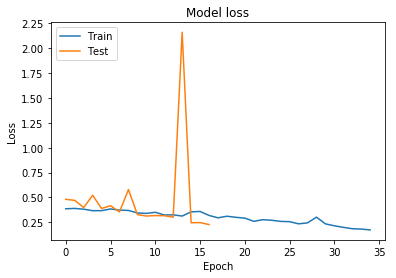

In [51]:
# Plot training & validation accuracy values

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png')

In [52]:
# #There must be an alternative to doing this
predictions = model.predict_generator(validation_generator, steps = 1) # NOTE THAT the input values should be normalized to be between 0 and 1

(10, 512, 512, 1)


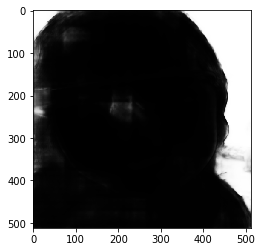

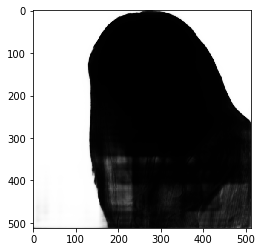

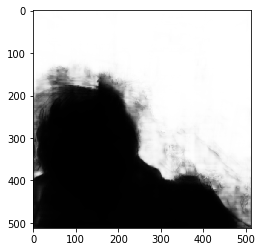

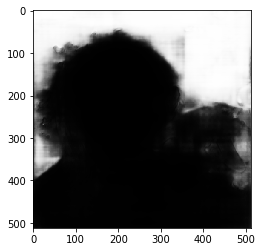

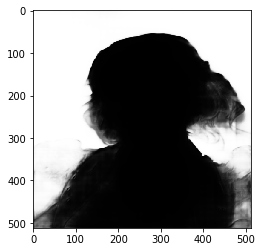

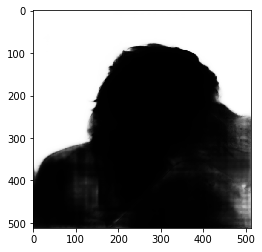

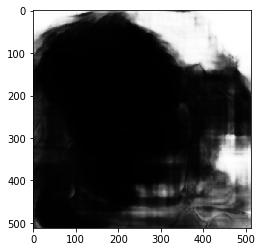

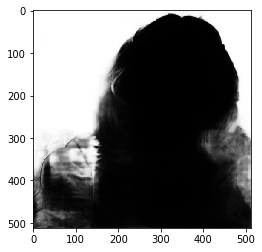

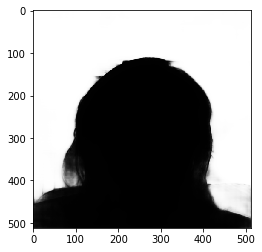

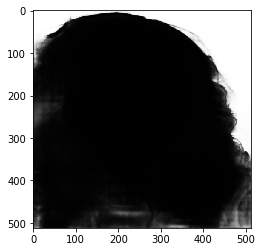

In [53]:
print(predictions.shape)

for i in range(predictions.shape[0]):
    img = predictions[i][:,:,0]
    img = np.trunc(img*255)
    img = img.astype(np.uint8)
    plt.imshow(img, cmap= 'Greys')
    plt.show()
#     plt.imshow(Y_train[i][:,:,0], cmap = 'Greys')
    plt.show()
    
    
# for i in range(IMG_WIDTH):
#     for j in range(IMG_HEIGHT):
#         print(img[i,j], end = ' ')
        
# for i in range(predictions.shape[0]):
#     plt.imshow(Y_test[i], cmap= 'Greys')
#     plt.show()
#     plt.imshow(255*predictions[i].reshape([IMG_WIDTH,IMG_HEIGHT]))
#     time.sleep(0.4)

### Now see how the model which had the best val_acc performs

In [ ]:
print(batchSize)
print(save_model_path)

In [ ]:
model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

In [ ]:
# #There must be an alternative to doing this
predictions = model.predict(X_test[:10]) # NOTE THAT the input values should be normalized to be between 0 and 1

In [ ]:
print(Y_test.shape)
print(predictions.shape)

for i in range(predictions.shape[0]):
    img = predictions[i][:,:,0]
    img = np.trunc(img*255)
    img = img.astype(int)
    plt.imshow(img, cmap= 'Greys')
    plt.show()
    plt.imshow(Y_test[i][:,:,0], cmap = 'Greys')
    plt.show()
    

#### Below is a test to see how the two generators are performing image augmentation

In [ ]:
!ls -a
!rm -rf ./train
!rm -rf ./train_masks
!mkdir ./train
!mkdir ./train_masks

In [ ]:
# ! ls -a ./train

In [ ]:
# os.listdir("./train")

In [ ]:
# import cv2
# img = cv2.imread('img_3_7408.png')
# print(type(img))
# for img_id in os.listdir("./train"):
#     img = cv2.imread(img_id)
#     print(img_id)
#     print(type(img))
#     plt.imshow(img)
#     plt.show()